  # Introduction
  Stroke is one of the leading causes of death and disability in the United States.
  Every year nearly 800,000 Americans suffer from stroke [[1](https://www.cdc.gov/stroke/facts.htm#:~:text=Every%2040%20seconds%2C%20someone%20in,minutes%2C%20someone%20dies%20of%20stroke.&text=Every%20year%2C%20more%20than%20795%2C000,United%20States%20have%20a%20stroke.)].
  Of these cases, nearly 140,000
  Americans die and another 75% of victims are left with some form of dysfunction
  or disability [[2](https://www.frontiersin.org/articles/10.3389/fneur.2021.649088/full)].

  However, 80% of all strokes are preventable with treatment and
  life style changes if detected early [[1](https://www.cdc.gov/stroke/facts.htm#:~:text=Every%2040%20seconds%2C%20someone%20in,minutes%2C%20someone%20dies%20of%20stroke.&text=Every%20year%2C%20more%20than%20795%2C000,United%20States%20have%20a%20stroke.)].
  Stroke detection has become increasingly
  important in trying to find factors that predict a stroke before it even happens.
  By performing data exploration, feature engineering, and machine learning modeling
  on a dataset containing many records of 10 key features the could predict stroke
  events, we hope to produce a machine learning model for predicting stroke events
  early to help curtail preventable deaths and ailments caused by stroke.

In [40]:
# import warnings
# warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from imblearn.pipeline import Pipeline   # required to use SMOTE
from imblearn.over_sampling import SMOTE # See Piazza Post @401

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


  # Data Cleaning, Preparation, and Initial Feature Engineering

  The data was aquired from a confidential source on [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset).

In [41]:
raw_data = pd.read_csv("healthcare-dataset-stroke-data.csv")
raw_data = raw_data.drop("id", axis=1)
raw_data.shape


(5110, 11)

  Here we can see the first 10 records in our raw dataset prior to any data
  cleaning or feature engineering. Note that we threw out the ID column when we read in the data.

In [42]:
raw_data.head(10)



,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


  ## Unknown and Missing Values

  Before we are able to model stroke, we have to clean our data first.
  It appears that we have two columns with NaNs and Unknowns: `bmi` and `smoking_status`.
  We must handle these values by either removing them or imputing them.
  Let's first explore the `smoking_status` column.

  ### Smoking Status `Unknowns`

  The missing value is labeled as "Unknown". We will need to look at the distribution of all
  of the labels before we are able to do anything.

There are 1544 records who have an "Unknown" smoking status.



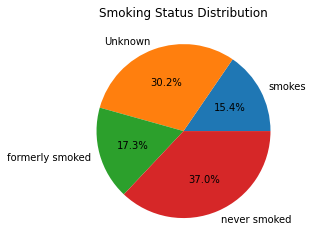

In [43]:
def get_count(df, col, val) :
  return df[df[col] == val].shape[0]

smk_lables = ['smokes', 'Unknown', 'formerly smoked', 'never smoked']
smk_cnt = []
for label in smk_lables :
  smk_cnt.append(get_count(raw_data, "smoking_status", label))

print("There are", smk_cnt[1], "records who have an \"Unknown\" smoking status.\n")

plt.title("Smoking Status Distribution")
plt.pie(smk_cnt, labels = smk_lables, autopct='%1.1f%%')
plt.show()


  Since over 30% of the data has an "unknown" smoking status, attempting to impute these values will be
  a significant challenge. Smoking is a [well-known](https://www.cdc.gov/tobacco/campaign/tips/diseases/heart-disease-stroke.html)
  stroke risk, and since this data is categorical, imputing these values may end up heavily
  biasing the data toward smokers/non-smokers.

  We also are unable to ascertain where and how this data was collected, which would have informed us
  on how to handle this data with more certainty.

  In a non-coursework setting, we would be spending significant amounts of time on trying different feature engineering
  techniques to handle this data. However, for the purposes of this project, we decided to move forward
  by simply dropping the unknown records. We still have thousands of other records to rely on.

  TODO (optional?) we can display summary statistics/distribution before and after dropping.

In [44]:
dropped_data = raw_data[raw_data.smoking_status != "Unknown"]
print("After removing the records with \"Unknown\" as their smoking status, we are left with", dropped_data.shape[0], "records.")


After removing the records with "Unknown" as their smoking status, we are left with 3566 records.


  #### Integer Encoding for `smoking_status`

  Now that we have dropped the unknown data, we are now left with 3 labels: `smokes`, `formerly smoked`, and
  `never smoked`. These three labels have an ordinal property to them, where `never smoked` is "better than"
  `formerly smoked`, which is "better than" `smokes`. To encode this property into our data,
  we will replace these values with 0, 1, and 2, respectively, creating a smoking metric where the higher value
  indicates a "worse smoking habit".

  While this encodes that ordinal property, it subtly implies that `smokes`, `formerly smoked`, and `never smoked`
  are only "different" from each other on this metric by 1. `smokes` is only "2-worse" than `never smoked`, and
  `formerly smoked` is exactly the midpoint between `smokes` and `never smoked`.

  This is yet another area we could explore in the feature-engineering iteration process, assigning different
  values to each label and seeing how they affect the labels. Of course, this only affects models that are
  distance-based, like K-Nearest Neighbors and Neural Networks. This should not affect models like Decision Trees.

In [45]:
dropped_data.loc[:, 'smoking_status'] = dropped_data.loc[:, 'smoking_status'].replace(["smokes"], 2)
dropped_data.loc[:, 'smoking_status'] = dropped_data.loc[:,'smoking_status'].replace(["formerly smoked"], 1)
dropped_data.loc[:, 'smoking_status'] = dropped_data.loc[:,'smoking_status'].replace(["never smoked"], 0)


/tmp/ipykernel_4522/2601154953.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped_data.loc[:, 'smoking_status'] = dropped_data.loc[:, 'smoking_status'].replace(["smokes"], 2)
/tmp/ipykernel_4522/2601154953.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped_data.loc[:, 'smoking_status'] = dropped_data.loc[:,'smoking_status'].replace(["formerly smoked"], 1)
/tmp/ipykernel_4522/2601154953.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

  ### BMI `NaN`s
  One natural question to ask is to figure out what proportion of the entries has a `NaN` in `bmi`.

In [46]:
num_bmi_nan = dropped_data["bmi"].isnull().sum()
total_entries = len(dropped_data.index)
num_bmi_nan / total_entries * 100


3.9259674705552436

  Only 3.9% of the data contains a `NaN` in the data. Since there aren't that many, it seems
  reasonable to impute the BMI with the other values.

  However, before we do so, this may introduce some bias toward stroke or non-stroke patients.

  How many of the missing values are classified as stroke patients compared to non-stroke patients?

In [47]:
# TODO what to do with this commented line?.... vvvv
# raw_data.drop(raw_data[raw_data['smoking_status'] == "Unknown"].index, inplace = True)

raw_stroke_bmi_data = dropped_data[dropped_data["stroke"] == 1]["bmi"]
raw_nonstroke_bmi_data = dropped_data[dropped_data["stroke"] == 0]["bmi"]

num_stroke_bmi_nan = raw_stroke_bmi_data.isnull().sum()
num_nonstroke_bmi_nan = raw_nonstroke_bmi_data.isnull().sum()

total_stroke_entries = len(raw_stroke_bmi_data.index)
total_nonstroke_entries = len(raw_nonstroke_bmi_data.index)

print("# of NaN BMI values in stroke:", num_stroke_bmi_nan)
print("# of Stroke Patients:", total_stroke_entries)
print("Percentage of NaN BMI in Stroke Patients:", num_stroke_bmi_nan / total_stroke_entries * 100, "\n")
print("# of NaN BMI values in nonstroke:", num_nonstroke_bmi_nan)
print("# of Nonstroke Patients:", total_nonstroke_entries)
print("Percentage of NaN BMI in Nonstroke Patients:", num_nonstroke_bmi_nan / total_nonstroke_entries * 100, "\n")


# of NaN BMI values in stroke: 22
# of Stroke Patients: 202
Percentage of NaN BMI in Stroke Patients: 10.891089108910892 

# of NaN BMI values in nonstroke: 118
# of Nonstroke Patients: 3364
Percentage of NaN BMI in Nonstroke Patients: 3.507728894173603 



  It appears that there are more missing BMI values for stroke patents than non-stroke patients,
  proportionally. Since these proportions are different, we will impute the BMI for stroke and
  non-stroke patients separately.

  By what metric should we impute the BMI? If the BMI has a significant skew, the metric by
  which we impute this data may impact our results.

(array([8.700e+01, 1.198e+03, 1.318e+03, 4.780e+02, 1.200e+02, 3.600e+01,
        6.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([11.5 , 19.55, 27.6 , 35.65, 43.7 , 51.75, 59.8 , 67.85, 75.9 ,
        83.95, 92.  ]),
 <BarContainer object of 10 artists>)

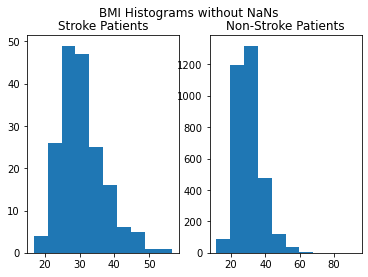

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("BMI Histograms without NaNs")

ax1.set_title("Stroke Patients") # TODO horizontal axes label
ax1.hist(raw_stroke_bmi_data[~np.isnan(raw_stroke_bmi_data)])

ax2.set_title("Non-Stroke Patients")
ax2.hist(raw_nonstroke_bmi_data[~np.isnan(raw_nonstroke_bmi_data)])


{'whiskers': [<matplotlib.lines.Line2D at 0x7f1f94a4d000>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1f94a4d5a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1f94a4cd30>],
 'medians': [<matplotlib.lines.Line2D at 0x7f1f94a4db40>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f1f94a4de10>],
 'means': []}

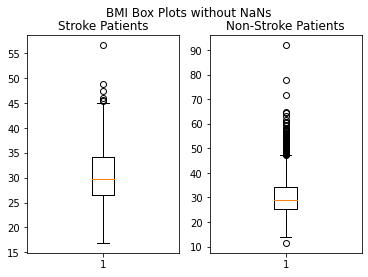

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("BMI Box Plots without NaNs")

ax1.set_title("Stroke Patients")
ax1.boxplot(raw_stroke_bmi_data[~np.isnan(raw_stroke_bmi_data)])

ax2.set_title("Non-Stroke Patients")
ax2.boxplot(raw_nonstroke_bmi_data[~np.isnan(raw_nonstroke_bmi_data)])


  The histograms and boxplots shows that the data seems to be partially right-skewed.
  Using the mean for imputation may lead to less-than-ideal results. Thus, we shall use
  the median to impute the missing BMI values.

  Since only 3.5% of the non-stroke patients have a NaN BMI, imputing the NaNs for the BMI
  before we run nested cross-validations should not affect the overall performance of the models,
  despite the data leakage. However, with 10.9% of the stroke-patients having NaN BMIs, this would
  be a significant instance of data leakage.

  For the purposes of this project, we opted to impute the data before we split the training and test
  data sets (see Piazza Post @395). Additionally, as you will see below, the median for both stroke and
  non-stroke patients end up being rather close, so the data leakage should not affect it too badly.
  Had we used the mean, we could not have gone away with this and would have had to resort to
  manual cross-validation and imputation.

In [50]:
stroke_median = raw_stroke_bmi_data.median()
nonstroke_median = raw_nonstroke_bmi_data.median()
print("BMI Median for Stroke Patients: ", stroke_median)
print("BMI Median for Nonstroke Patients: ", nonstroke_median)

imputed_stroke_data = dropped_data[dropped_data["stroke"] == 1].fillna(stroke_median)
imputed_nonstroke_data = dropped_data[dropped_data["stroke"] == 0].fillna(nonstroke_median)
imputed_data = pd.concat([imputed_stroke_data, imputed_nonstroke_data])
imputed_data.head(10)


BMI Median for Stroke Patients:  29.75
BMI Median for Nonstroke Patients:  29.0


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,1,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.75,0,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,0,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,2,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,0,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.00,1,1
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.40,0,1
7,Female,69.0,0,0,No,Private,Urban,94.39,22.80,0,1
10,Female,81.0,1,0,Yes,Private,Rural,80.43,29.70,0,1
11,Female,61.0,0,1,Yes,Govt_job,Rural,120.46,36.80,2,1


  ## One-Hot Encoding

  Since we are performing various different types of modeling, where some cannot handle categorical data types,
  we will be doing one-hot encoding on the categorical features.

  ### Binary Features

In [51]:
print(imputed_data["ever_married"].unique())
print(imputed_data["Residence_type"].unique())


['Yes' 'No']
['Urban' 'Rural']


  `ever_married`, and `Residence_type` are both binary categorical features. We can use Pandas'
  `get_dummies()` function with `drop_first = True` to limit the dimensionality.

In [52]:
# The features and class columns are separately handled due to sklearn's API.
binary_data_X = pd.get_dummies(imputed_data.iloc[:, :10], columns=["ever_married", "Residence_type"], drop_first=True)
binary_data_X.head()


,gender,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,ever_married_Yes,Residence_type_Urban
0,Male,67.0,0,1,Private,228.69,36.60,1,1,1
1,Female,61.0,0,0,Self-employed,202.21,29.75,0,1,0
2,Male,80.0,0,1,Private,105.92,32.50,0,1,0
3,Female,49.0,0,0,Private,171.23,34.40,2,1,1
4,Female,79.0,1,0,Self-employed,174.12,24.00,0,1,0


  ### Non-binary Features

In [53]:
# TODO consider dropping the gender_other column, since gender identity probably doesn't affect much in the way
# TODO of stroke prediction. also, there are very few gender_others.
print(binary_data_X["gender"].unique()) 
print(binary_data_X["work_type"].unique())


['Male' 'Female' 'Other']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']


  Since `gender` and `work_type` are not binary features, we can use the same function, but with
  `drop_first = False`.

In [54]:
data_X = pd.get_dummies(binary_data_X, columns=["gender", "work_type"], drop_first=False)
data_Y = imputed_data.iloc[:, 10].values.ravel()
data = pd.concat([data_X, imputed_data.iloc[:, 10]], axis=1)


  ## Additional Data Exploration

  Now that the data has been cleaned, we can look at some of its features and think of potential
  additional feature engineering techniques.

  ### Correlation and Scatter Matrix for Age, Glucose Level, BMI, and Stroke

  These features are originally numeric, not categorical or binary.

                        age  avg_glucose_level       bmi    stroke
age                1.000000           0.232698  0.076733  0.250794
avg_glucose_level  0.232698           1.000000  0.149058  0.128714
bmi                0.076733           0.149058  1.000000  0.010599
stroke             0.250794           0.128714  0.010599  1.000000


array([[<AxesSubplot:xlabel='age', ylabel='age'>,
        <AxesSubplot:xlabel='avg_glucose_level', ylabel='age'>,
        <AxesSubplot:xlabel='bmi', ylabel='age'>,
        <AxesSubplot:xlabel='stroke', ylabel='age'>],
       [<AxesSubplot:xlabel='age', ylabel='avg_glucose_level'>,
        <AxesSubplot:xlabel='avg_glucose_level', ylabel='avg_glucose_level'>,
        <AxesSubplot:xlabel='bmi', ylabel='avg_glucose_level'>,
        <AxesSubplot:xlabel='stroke', ylabel='avg_glucose_level'>],
       [<AxesSubplot:xlabel='age', ylabel='bmi'>,
        <AxesSubplot:xlabel='avg_glucose_level', ylabel='bmi'>,
        <AxesSubplot:xlabel='bmi', ylabel='bmi'>,
        <AxesSubplot:xlabel='stroke', ylabel='bmi'>],
       [<AxesSubplot:xlabel='age', ylabel='stroke'>,
        <AxesSubplot:xlabel='avg_glucose_level', ylabel='stroke'>,
        <AxesSubplot:xlabel='bmi', ylabel='stroke'>,
        <AxesSubplot:xlabel='stroke', ylabel='stroke'>]], dtype=object)

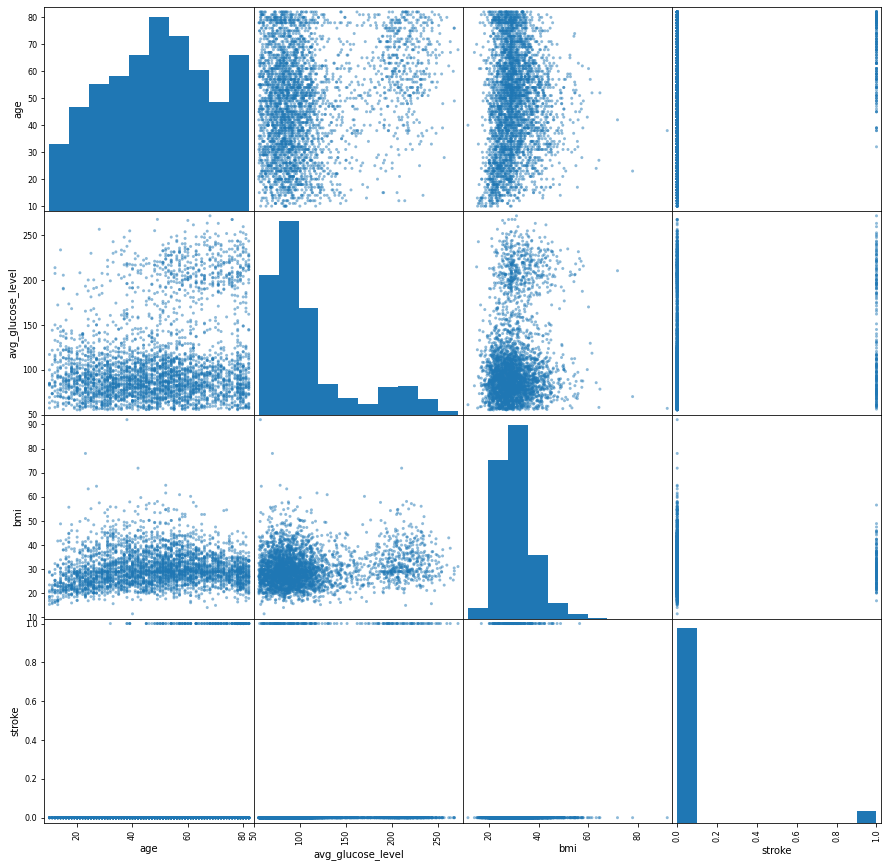

In [55]:
print(data.iloc[:, [0, 3, 4, 16]].corr())
pd.plotting.scatter_matrix(data.iloc[:, [0, 3, 4, 16]], figsize=(15, 15))


  None of these features have a strong correlation with one another, so we cannot justify dropping one of
  these features.
  TODO comment on the scatter matrix. Cite how age and blood sugar changes together, and the data doesn't show that
  TODO which then implies that the blood sugar was taken at random times...

  Also, there are no clear, direct correlation between any of these features with stroke.

  ### Correlation in Gender

In [56]:
print(data.iloc[:, [8, 9, 10, 16]].corr())


               gender_Female  gender_Male  gender_Other    stroke
gender_Female       1.000000    -0.999413     -0.020735 -0.015492
gender_Male        -0.999413     1.000000     -0.013520  0.015634
gender_Other       -0.020735    -0.013520      1.000000 -0.004104
stroke             -0.015492     0.015634     -0.004104  1.000000


  As seen above, the `gender_Female` and `gender_Male` features obviously have strong negative correlation
  with each other. However, we should not necessarily drop one or the other. Women appear to have a
  [higher risk](https://www.ahajournals.org/doi/10.1161/CIRCRESAHA.121.319915#:~:text=In%20the%20United%20States%2C%20the,55%2Dyear%2Dold%20individual.&text=Stroke%20is%20more%20likely%20to,heart%20disease%20is%20more%20common.)
  of having a stroke than men. Of course, the features list "gender" and not "sex", but people who do not
  conform to gender norms often experience [higher levels of stress](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4201643/)
  and stress is a [known risk factor for stroke](https://health.clevelandclinic.org/stressed-work-may-higher-risk-stroke/).

  Thus, treating each gender label in this data separately, at least initially, seems to be a good idea.

  ### Correlation of Work Types, Residences, and Stroke

In [57]:
print(data.iloc[:, [7, 11, 12, 13, 14, 15, 16]].corr())


                         Residence_type_Urban  work_type_Govt_job  \
Residence_type_Urban                 1.000000            0.010759   
work_type_Govt_job                   0.010759            1.000000   
work_type_Never_worked               0.034789           -0.026376   
work_type_Private                   -0.019132           -0.561116   
work_type_Self-employed              0.006829           -0.200778   
work_type_children                   0.003666           -0.059015   
stroke                               0.007872           -0.018024   

                         work_type_Never_worked  work_type_Private  \
Residence_type_Urban                   0.034789          -0.019132   
work_type_Govt_job                    -0.026376          -0.561116   
work_type_Never_worked                 1.000000          -0.083849   
work_type_Private                     -0.083849           1.000000   
work_type_Self-employed               -0.030003          -0.638266   
work_type_children         

  Based on the correlation matrix above, there are 2 feature pairs that are moderately correlated
  with one another. `private` sector jobs appear to share decent correlations with `government` and `self-employment`.
  One option to reduce the dimensionality of the data set would have been to group some of these features together.
  However, this is probably not a great idea since, like the stress cited before, [work stress](https://www.aan.com/PressRoom/Home/PressRelease/1412)
  is also a known risk factor for strokes. Different work types have different levels of stress, so
  combining them would be bad for the data.

  We could attempt to group these features by varying levels of "work stress", but these work types are too broad
  to reasonably group them like that.

  Like before, there are no clear, direct correlations between any of these features with stroke.

  # Initial Evaluation of Various Models

  Before we go into implementing the individual models and computing their performance on this data,
  we must first address how we are going to evaluate each model.

In [ ]:
stroke_data = data[data["stroke"] == 1]
nonstroke_data = data[data["stroke"] == 0]

stroke_type = ["stroke", "nonstroke"]
stroke_len = [len(stroke_data), len(nonstroke_data)]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(stroke_type, stroke_len)
ax.set_title("Stroke vs Nonstroke Patients Counts in Data")


  As shown above, there is a significant class imbalance in our data set. If we decided to use the normal
  k-folds procedure, there is a significant chance that some training splits will only have
  non-stroke patients. By training on that imbalanced data, the models will be forced to only predict "nonstroke".

  In order to resolve this train/test splitting problem, we can use `StratifiedKFold()`, which will preserve
  the relative percentage of stroke/nonstroke records in each fold. By default, this method uses `k=5` folds.

  Another option is to use SMOTE, to oversample the stroke records and artificially create new ones. Due to
  the low number of stroke records we have available in the data, we will use Imbalanced-Learn's `SMOTE()` sampling
  method instead of the `StratifiedKFold()`

  Additionally, we must carefully consider the scoring metric by which we will grade each model's performance,
  during and after nested cross-validation. Using accuracy is not useful, since each model can simply predict
  "nonstroke" and get extremely high accuracy scores. The obvious solution would be to use the `f1`-scoring metric

  Having false-positives has a very low "societal" cost. If the model falsely predicts that a patient will have
  a stroke (or at the very least a high risk of one), that would be okay, since the patient will merely have
  to try and change some of their lifestyles, although this may inconvenience them.

  However, false-negatives has a massive cost. If the model falsely predicts that a patient will not have a
  stroke, that patient may die from that stroke, or be left with lifelong symptoms.

  As such, in order to minimize false-negatives, regardless of the false-positives, we could use `recall`.
  However, this may incentivize some algorithms to simply evaluate everything as stroke, which is the opposite of
  what we want.

  In order to balance both of these options, we will stick with the `f1`-score.

The following line of code is simply used to keep track of the largest `f1`-score.

In [ ]:
performance_dict = {}

  ## Decision Trees

  Decision Trees can handle non-scaled data and is not affected by the curse of dimensionality. Thus,
  we can simply create a normal `DecisionTreeClassifier()` object, pass in a variety of hyperparameters,
  and evaluate its performance.

 This model took 37.3 seconds to run on the CS lab machines.

In [ ]:
smote = SMOTE() # TODO check if setting random state or not affects the outcome
clf = DecisionTreeClassifier()
pipeline = Pipeline([("sampler", smote),
                     ("tree", clf)])

params = {
    "tree__max_depth": list(range(10, 24, 5)),
    "tree__min_samples_leaf": [5, 10, 15, 20],
    "tree__max_features": list(range(5, 18, 2))
}

grid_search = GridSearchCV(pipeline, params, cv=5, scoring="f1")
pred_Y = cross_val_predict(grid_search, data_X, data_Y, cv=5)
general_score = f1_score(data_Y, pred_Y)
print("Generalization F1 Score: ", general_score)
print("Confusion Matrix: \n", confusion_matrix(data_Y, pred_Y))
print("Classification Report: \n", classification_report(data_Y, pred_Y))

performance_dict['DecisionTreeClassifier'] = general_score


 As seen above, the decision tree classifier performed rather poorly. Although
 it achieved a high accuracy, it achieves that accuracy by guessing most of the
 records to be non-stroke (as we will see rest of the models).

  ## Naive Bayes

  Much like Decision Trees, Naive Bayes avoids the problems with the curse of dimensionality. Additionally, since
  we have already converted our features into numerical values, we can simply use sklearn's `GaussianNB()` classifier.
  Also, since there are no notable hyperparmeters to consider (at least from our course), we can simply
  use `cross_val_predict()` to evaluate this model.

 This model took 0.1 seconds to run on the CS lab machines.

In [ ]:
smote = SMOTE()
clf = GaussianNB()
pipeline = Pipeline([("sampler", smote),
                     ("clf", clf)])

pred_Y = cross_val_predict(pipeline, data_X, data_Y, cv=5)

general_score = f1_score(data_Y, pred_Y)
print("Generalization F1 Score: ", general_score)
print("Confusion Matrix: \n", confusion_matrix(data_Y, pred_Y))
print("Classification Report: \n", classification_report(data_Y, pred_Y))

performance_dict['GaussianNB'] = general_score


 The result for Naive Bayes is the only noteworthy model. Although it does not
 have a remarkable f1-score, its recall on the stroke records is incredibly high
 at 88%. Of course, this resulted in a significant amount of false positives
 and a precision of only 6%. However, the number of false negatives is heavily diminished.

 Since this model is statistics-based, one could argue that the people with
 false positives are statistically likely to have a stroke. However, this result
 may have been from potentially redundant features.

  ## K-Nearest Neighbors

  K-Nearest Neighbors
  uses distance calculations to classify new objects. As such, it suffers under the curse of dimensionality,
  and we must use a method to reduce the number of dimensions, like Principle Component Analysis (PCA).

  Additionally, we must also scale the data so that features like `age` do not single-handedly determine the
  distance calculations. This scaling is also essential for PCA.

  One option for scaling is to standardize the data based on the mean and standard deviation - converting each
  value into a z-score (`StandardScaler()`)
  Note that it takes a substantial amount of time to run the following, due to the shear number of distance calculations
  required.

 This model took 1 minute 46 seconds to run on the CS lab machines.

In [ ]:
smote = SMOTE()
scaler = StandardScaler()
pca = PCA()
clf = KNeighborsClassifier(n_jobs=-1) # n_jobs is set to use all processors for faster computation

pipeline = Pipeline([("sampler", smote),
                     ("scaler", scaler),
                     ("pca", pca),
                     ("knn", clf)])

params = {
    "pca__n_components": list(range(6, 17, 1)),
    "knn__n_neighbors": list(range(10, 31, 5))
}

grid_search = GridSearchCV(pipeline, params, cv=5, scoring="f1")
pred_Y = cross_val_predict(grid_search, data_X, data_Y, cv=5)
general_score = f1_score(data_Y, pred_Y)
print("Generalization F1 Score: ", general_score)
print("Confusion Matrix: \n", confusion_matrix(data_Y, pred_Y))
print("Classification Report: \n", classification_report(data_Y, pred_Y))
performance_dict['KNeighborsClassifier'] = general_score


  TODO make notes on KNN
  !Additionally, PCA works by maximizing the variance in the data
  !in each iteration. Using normalization

  ## Support Vector Machines

  Much like KNN, we need to scale and reduce the dimensionality of the data with SVMs. However, as we saw before,
  it seems like "" is better for the data, in general, so we shall stick to "" for the rest of the models.

 This model took 6 minutes 43 seconds to run on the CS lab machines.

In [ ]:
smote = SMOTE()
scaler = StandardScaler() # TODO check this
pca = PCA()
clf = SVC()
pipeline = Pipeline([("sampler", smote),
                     ("scaler", scaler),
                     ("pca", pca),
                     ("svm", clf)])

params = {
    "pca__n_components": list(range(5, 17, 1)),
    "svm__kernel": ["poly", "rbf", "sigmoid"]
}

grid_search = GridSearchCV(pipeline, params, cv=5, scoring="f1")
pred_Y = cross_val_predict(grid_search, data_X, data_Y, cv=5)
general_score = f1_score(data_Y, pred_Y)
print("Generalization F1 Score: ", general_score)
print("Confusion Matrix: \n", confusion_matrix(data_Y, pred_Y))
print("Classification Report: \n", classification_report(data_Y, pred_Y))
performance_dict['SVM'] = general_score


  ## Neural Networks (Multi-Layer Perceptrons)


 TODO some intro to neural nets?
 This model took 9 minutes 10 seconds to run on the CS lab machines.

In [ ]:
smote = SMOTE()
scaler = StandardScaler()
clf = MLPClassifier()
pipeline = Pipeline([("smote", smote),
                     ("scaler", scaler),
                     ("nn", clf)])

params = {
    "nn__hidden_layer_sizes": [(40,), (60,), (80,), (100,)],
    "nn__activation": ["logistic", "tanh", "relu"]
}

grid_search = GridSearchCV(pipeline, params, cv=5, scoring="f1")
pred_Y = cross_val_predict(grid_search, data_X, data_Y, cv=5)
general_score = f1_score(data_Y, pred_Y)
print("Generalization F1 Score: ", general_score)
print("Confusion Matrix: \n", confusion_matrix(data_Y, pred_Y))
print("Classification Report: \n", classification_report(data_Y, pred_Y))
performance_dict['MLPClassifier'] = general_score


  ## Random Forest Ensemble

  We can also use ensemble methods like `RandomForestClassifier()`. Much like normal decision
  trees, we do not need to scale the data, nor do we need PCA. However, we still need a Pipeline
  object in order to use SMOTE.

 This model took 8 minutes 10 seconds to run on the CS lab machines.

In [ ]:
smote = SMOTE()
clf = RandomForestClassifier()
pipeline = Pipeline([("sampler", smote),
                     ("rfc", clf)])

params = {
    "rfc__max_depth": list(range(35, 46, 1)),
    "rfc__min_samples_leaf": list(range(8, 13, 2)),
    "rfc__max_features": ["sqrt", "log2"]
}

grid_search = GridSearchCV(pipeline, params, cv=5, scoring="f1")
pred_Y = cross_val_predict(grid_search, data_X, data_Y, cv=5)
general_score = f1_score(data_Y, pred_Y)
print("Generalization F1 Score: ", general_score)
print("Confusion Matrix: \n", confusion_matrix(data_Y, pred_Y))
print("Classification Report: \n", classification_report(data_Y, pred_Y))
performance_dict['RandomForestClassifier'] = general_score

  ## Adaptive Boosting Ensemble

 Another ensemble model we can use is `AdaBoostClassifier`. Since the base classifier is also decision tree stumps, we can do a similar operation to the previous ensemble method.

 This model took 43 seconds to run on the CS lab machines.

In [ ]:
smote = SMOTE()
clf = AdaBoostClassifier()
pipeline = Pipeline([("sampler", smote),
                     ("adc", clf)])

params = {
    "adc__n_estimators": list(range(50, 201, 50))
}

grid_search = GridSearchCV(pipeline, params, cv=5, scoring="f1")
pred_Y = cross_val_predict(grid_search, data_X, data_Y, cv=5)
general_score = f1_score(data_Y, pred_Y)
print("Generalization F1 Score: ", general_score)
print("Confusion Matrix: \n", confusion_matrix(data_Y, pred_Y))
print("Classification Report: \n", classification_report(data_Y, pred_Y))
performance_dict['AdaBoostClassifier'] = general_score


In [ ]:
# ## Model Performance Comparison and Summary

for key in performance_dict.keys():
    print(key, ": ", performance_dict[key])

best_model = max(performance_dict, key=performance_dict.get)
performance_dict = {}

 As seen above, the best performing model in terms of f1-score is the random
 forest classifier. However, it only achieved an f1-score of 19%.

 On the other hand, when we are considering the recall values of each model,
 the Naive Bayes model performed the best in recall, even though none of the
 models were trained using that metric.

 If we stopped here, we would use the Naive Bayes model as our final model.

 # Feature Engineering

 Now that we have evaluated some models without feature engineering, we should try and improve upon them through feature engineering.
 We can feature engineer the glucose levels with other numeric features to incorporate some known-correlations
 in the data.

 ## Average Glucose Level to Age Ratio

 This suggests that it can be useful to calculate an "average glucose to age" ratio based on binned values.
 Studies indicate that average glucose values tend to differ in different age groups such as from `0-6`, `6-12`, `13-19`, `20-65`, and `65+`.
 By calculating the average glucose level of each of these groups then calculating the ratio
 relative to this average we can generate a ratio that better represents the "unusualness" of the
 average glucose in a particular record.

In [58]:
data["age"].describe()

count    3566.000000
mean       48.853898
std        18.874375
min        10.000000
25%        34.000000
50%        50.000000
75%        63.000000
max        82.000000
Name: age, dtype: float64

<AxesSubplot:>

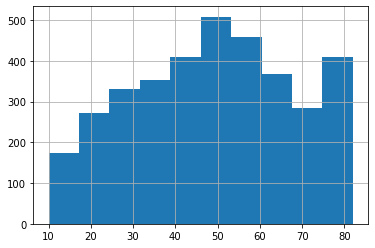

In [59]:
data["age"].hist()

 Based on the fact that the minimum age for this data is 10, we decided to bin the ages into
 `0-12`, `13-19`, `20-65`, and `65+`.

In [60]:
group_one = 0 # TODO cite studies
count_one = 0
group_two = 0
count_two = 0
group_three = 0
count_three = 0
group_four = 0
count_four = 0

for age in data["age"]:
   if age <= 12:
      group_one += age
      count_one += 1
   elif age <= 19:
      group_two += age
      count_two += 1
   elif age <= 65:
      group_three += age
      count_three += 1
   else:
      group_four += age
      count_four += 1

# average age of each group
group_one_avg = group_one / count_one
group_two_avg = group_two / count_two
group_three_avg = group_three / count_three
group_four_avg = group_four / count_four

glucose_age_ratio = []

for age in data["age"]:
    if age <= 12:
        glucose_age_ratio.append(age/group_one_avg)
    elif age <= 19:
        glucose_age_ratio.append(age/group_two_avg)
    elif age <= 65:
        glucose_age_ratio.append(age/group_three_avg)
    else:
        glucose_age_ratio.append(age/group_four_avg)

data["glucose_age_ratio"] = glucose_age_ratio
data_X = data.drop(columns=["stroke"])
data_Y = data["stroke"]

data_X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,ever_married_Yes,Residence_type_Urban,gender_Female,gender_Male,gender_Other,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,glucose_age_ratio
0,67.0,0,1,228.69,36.60,1,1,1,0,1,0,0,0,1,0,0,0.900368
1,61.0,0,0,202.21,29.75,0,1,0,1,0,0,0,0,0,1,0,1.384436
2,80.0,0,1,105.92,32.50,0,1,0,0,1,0,0,0,1,0,0,1.075066
3,49.0,0,0,171.23,34.40,2,1,1,1,0,0,0,0,1,0,0,1.112088
4,79.0,1,0,174.12,24.00,0,1,0,1,0,0,0,0,0,1,0,1.061628


In [61]:
data_X["glucose_age_ratio"].describe()

count    3566.000000
mean        1.000000
std         0.248308
min         0.453913
25%         0.862435
50%         1.021305
75%         1.167194
max         1.475218
Name: glucose_age_ratio, dtype: float64

<AxesSubplot:>

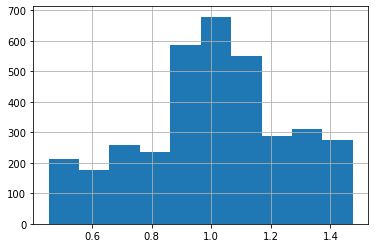

In [62]:
data_X["glucose_age_ratio"].hist()

 ## Diabetes Evidence

 [Some studies](https://my.clevelandclinic.org/health/diseases/9812-diabetes-and-stroke) indicate that having diabetes increases your risk of a stroke by
 1.5 times. Although diabetes was not a recorded feature in the dataset, using
 the average glucose level we can feature engineer to create a binary "diabetes_evidence"
 feature that reports if there is evidence of diabetes based on glucose level. 

<AxesSubplot:>

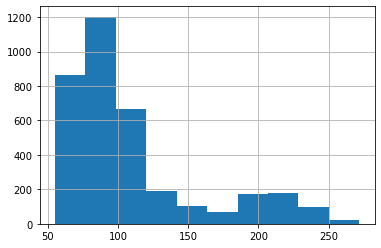

In [65]:
data["avg_glucose_level"].hist()

Although we are not given the units of the blood sugar numbers, we know that the normal range of blood glucose levels are in the [50 to 150 mg/dL](https://www.researchgate.net/figure/Distribution-of-percent-of-blood-sugar-measurements-during-usual-clinical-care-use-of_fig2_38063327) range, approximately. So we can assume that the units are `mg/dL`.

Although it states that this is the "average" glucose level, we do not truly know how this data was collected. We must consider this because blood sugar is known to rise soon after eating and fall during fasts. Thus, let us also assume that this was a "random" blood sugar test. According to the [Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/diabetes/diagnosis-treatment/drc-20371451), a blood sugar of `200 mg/dL` at any point suggests diabetes.

We can create a new binary feature called `diabetes_risk` by using the `average_glucose_level`.

In [69]:
diabetes_risk = []
for avg_glucose_level in data["avg_glucose_level"]:
   if avg_glucose_level >= 200:
      diabetes_risk.append(1)
   else:
      diabetes_risk.append(0)

data["diabetes_evidence"] = diabetes_risk
data.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,ever_married_Yes,Residence_type_Urban,gender_Female,gender_Male,gender_Other,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,stroke,glucose_age_ratio,diabetes_evidence,glucose_bmi_ratio
5102,57.0,0,0,77.93,21.7,0,1,0,1,0,0,0,0,1,0,0,0,1.293653,0,3.591244
5105,80.0,1,0,83.75,29.0,0,1,1,1,0,0,0,0,1,0,0,0,1.075066,0,2.887931
5106,81.0,0,0,125.20,40.0,0,1,1,1,0,0,0,0,0,1,0,0,1.088505,0,3.130000
5107,35.0,0,0,82.99,30.6,0,1,0,1,0,0,0,0,0,1,0,0,0.794348,0,2.712092
5108,51.0,0,0,166.29,25.6,1,1,0,0,1,0,0,0,1,0,0,0,1.157479,0,6.495703


In [68]:
data["diabetes_evidence"].describe()

count    3566.000000
mean        0.103758
std         0.304989
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: diabetes_evidence, dtype: float64

 ### Average Glucose Level to BMI Ratio

 The average glucose level can also vary according to
 BMI. According to [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7112218/),
 the results section states that "Mean Blood glucose levels are 10 mg/dl higher among overweight or obese" individuals.

 Additionally, [this paper](https://jamanetwork.com/journals/jamainternalmedicine/fullarticle/754810)
 notes that individuals with high BMIs also have a higher risk of stroke.
 
 To provide a metric to measure a person's glucose level
 in respect to their BMI, we can make a ratio that divides
 a person's average glucose level by their BMI.

In [67]:
glucose_bmi_ratio = []

for index, row in data.iterrows():
   glucose_bmi_ratio.append(row["avg_glucose_level"]/row["bmi"])

data["glucose_bmi_ratio"] = glucose_bmi_ratio
data.head()


,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,ever_married_Yes,Residence_type_Urban,gender_Female,gender_Male,gender_Other,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,stroke,glucose_age_ratio,diabetes_evidence,glucose_bmi_ratio
0,67.0,0,1,228.69,36.60,1,1,1,0,1,0,0,0,1,0,0,1,0.900368,1,6.248361
1,61.0,0,0,202.21,29.75,0,1,0,1,0,0,0,0,0,1,0,1,1.384436,1,6.796975
2,80.0,0,1,105.92,32.50,0,1,0,0,1,0,0,0,1,0,0,1,1.075066,0,3.259077
3,49.0,0,0,171.23,34.40,2,1,1,1,0,0,0,0,1,0,0,1,1.112088,0,4.977616
4,79.0,1,0,174.12,24.00,0,1,0,1,0,0,0,0,0,1,0,1,1.061628,0,7.255000


In [72]:
data["glucose_bmi_ratio"].describe()

count    3566.000000
mean        3.733199
std         1.695130
min         0.618478
25%         2.554261
50%         3.259659
75%         4.418947
max        15.467516
Name: glucose_bmi_ratio, dtype: float64

<AxesSubplot:>

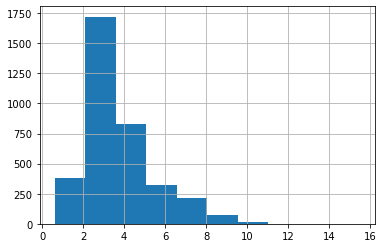

In [70]:
data["glucose_bmi_ratio"].hist()

 # Testing the Models with New Features

 With this new feature, the following runs the same `7` models as we did before for comparison.